## **11. Tracking a Ball in a Video**

*   Use the HSV-based object detection code to track a colored ball in a recorded video.

In [16]:
!git clone https://github.com/MEXECardenas/9-16
%cd 9-16
from IPython.display import clear_output
clear_output()

In [ ]:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
import os

# Set input video path
video_path = "Video/ball.mp4"

# Initialize video capture
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Cannot open input video. Check if the file exists at {video_path}")
    raise SystemExit

# Get video frame dimensions
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

if frame_width == 0 or frame_height == 0:
    print("Error: Invalid frame dimensions. Using default resolution.")
    frame_width, frame_height = 1920, 1080

# Initialize video writer
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (frame_width, frame_height))

if not out.isOpened():
    print("Error: Video writer not initialized properly.")
    cap.release()
    raise SystemExit

ball_positions = []

# Process the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define HSV range to exclude the green background
    lower_green = np.array([35, 40, 40])  # Green range lower bound
    upper_green = np.array([85, 255, 255])  # Green range upper bound
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Invert the green mask to focus on non-green areas (ball)
    non_green_mask = cv2.bitwise_not(green_mask)

    # Convert the frame to grayscale for detecting black and white patterns
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply the non-green mask to the grayscale image
    masked_gray = cv2.bitwise_and(gray, gray, mask=non_green_mask)

    # Threshold the grayscale image to emphasize white and black areas
    _, thresholded = cv2.threshold(masked_gray, 50, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to reduce noise
    thresholded = cv2.erode(thresholded, None, iterations=2)
    thresholded = cv2.dilate(thresholded, None, iterations=2)

    # Find contours in the processed mask
    contours, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    center = None

    if len(contours) > 0:
        # Get the largest contour (assuming it's the ball)
        c = max(contours, key=cv2.contourArea)

        # Calculate the moments of the contour
        M = cv2.moments(c)

        if M["m00"] != 0:
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

        # Add the center to the ball positions if valid
        if center:
            ball_positions.append(center)

        # Draw lines connecting ball's previous positions
        if len(ball_positions) > 1:
            for i in range(1, len(ball_positions)):
                cv2.line(frame, ball_positions[i - 1], ball_positions[i], (0, 0, 255), 2)

    # Write the processed frame to the output video
    out.write(frame)

cap.release()
out.release()

# Check if the output file exists
if os.path.exists('output.mp4'):
    print("Video processing complete. Downloading 'output.mp4'...")
    files.download('output.mp4')
else:
    print("Error: 'output.mp4' not found.")


Video processing complete. Downloading 'output.mp4'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **12. Highlighting Detected Faces**

* Apply the Haar cascade face detection code to identify and highlight multiple faces in family or crowd photos.

In [3]:
!pip install mediapipe
clear_output()

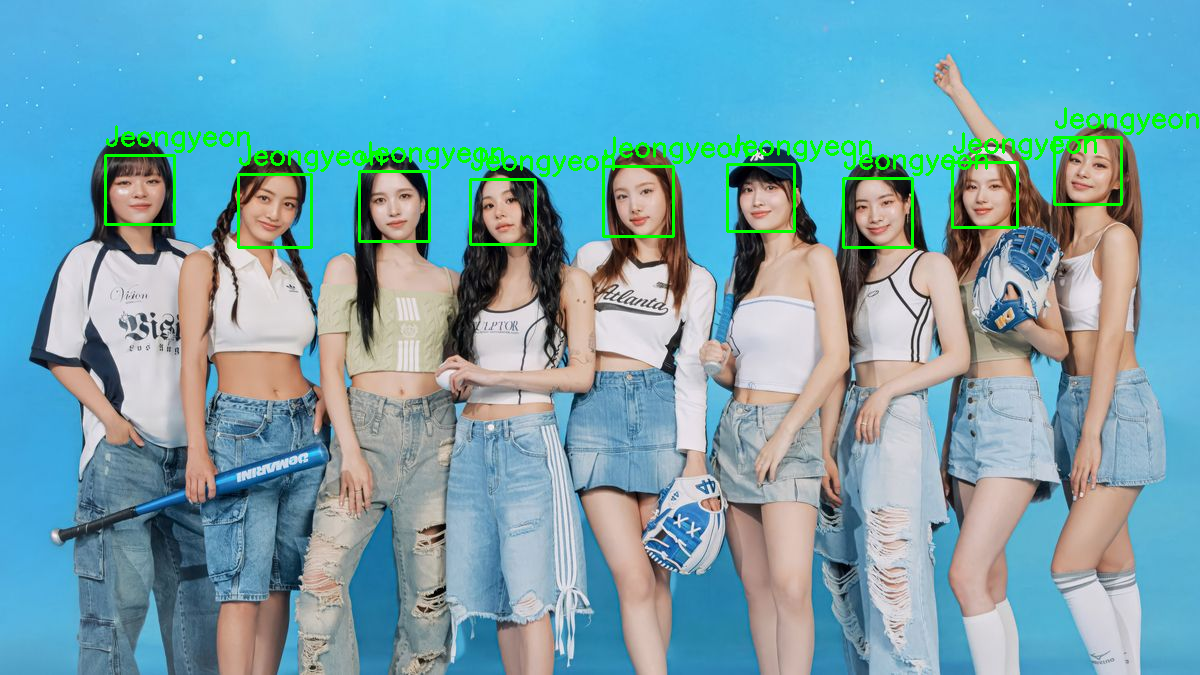

In [52]:
import cv2
import mediapipe as mp
import numpy as np
from scipy.spatial.distance import cosine
from google.colab.patches import cv2_imshow

# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=10, refine_landmarks=True)
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.2)

# Load the image
image = cv2.imread('Pictures/twice2.jpg')

# Convert the image to grayscale (for Haar detection)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Optional: Apply histogram equalization for better contrast
gray = cv2.equalizeHist(gray)

# Optional: Apply Gaussian Blur to remove noise
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# Load the pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier('Files/haarcascade_frontalface_default.xml')

# Detect faces using Haar Cascade
faces_haar = face_cascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=8,
    minSize=(60, 60),
    flags=cv2.CASCADE_SCALE_IMAGE
)

# Alternatively, use MediaPipe face detection (more robust)
results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
faces_mediapipe = []
if results.detections:
    for detection in results.detections:
        bboxC = detection.location_data.relative_bounding_box
        ih, iw, _ = image.shape
        x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
        faces_mediapipe.append((x, y, w, h))

# Combine the detected faces from both Haar and MediaPipe
faces = list(faces_haar) + list(faces_mediapipe)

# Sort faces by x and y coordinates to avoid misclassifications
faces = sorted(faces, key=lambda x: (x[0], x[1]))

# Load known face images and labels
known_face_images = [
    'Pictures/NY.jpg', 'Pictures/JY.jpg', 'Pictures/MM.jpg',
    'Pictures/SN.jpg', 'Pictures/JH.jpg', 'Pictures/MN.jpg',
    'Pictures/DH.jpg', 'Pictures/CY.jpg', 'Pictures/TY.jpg'
]
known_face_labels = [
    'Nayeon', 'Jeongyeon', 'Momo', 'Sana', 'Jihyo',
    'Mina', 'Dahyun', 'Chaeyoung', 'Tzuyu'
]

# Helper function: Extract face embeddings using normalized landmarks
def extract_face_embedding(image, landmarks):
    h, w, _ = image.shape
    embedding = []
    for lm in landmarks:
        # Normalize coordinates by image dimensions
        embedding.append(lm.x)
        embedding.append(lm.y)
    return np.array(embedding)

# Prepare the list of known face embeddings
known_face_embeddings = []
for image_path in known_face_images:
    known_image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(known_image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            embedding = extract_face_embedding(known_image, face_landmarks.landmark)
            known_face_embeddings.append(embedding)

# Process the detected faces and compare with known faces
for (x, y, w, h) in faces:
    # Crop and preprocess the detected face
    face_image = image[y:y+h, x:x+w]
    face_image_resized = cv2.resize(face_image, (224, 224))  # Resize for consistency
    rgb_face_image = cv2.cvtColor(face_image_resized, cv2.COLOR_BGR2RGB)

    # Use Mediapipe to get face landmarks
    results = face_mesh.process(rgb_face_image)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            face_embedding = extract_face_embedding(face_image_resized, face_landmarks.landmark)

            # Compare the embedding with known faces
            best_match = "Unknown"
            best_similarity = -1  # Initialize with the lowest similarity

            for idx, known_embedding in enumerate(known_face_embeddings):
                # Calculate Cosine similarity
                similarity = 1 - cosine(face_embedding, known_embedding)

                # Update match if similarity is higher than threshold
                if similarity > best_similarity and similarity > 0.6:  # Lower threshold for more sensitive matching
                    best_similarity = similarity
                    best_match = known_face_labels[idx]

            # Draw a rectangle around the face
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Label the face
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image, best_match, (x, y - 10), font, 0.9, (0, 255, 0), 2)

# Display the image with detected and recognized faces
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


## **13. Extracting Contours for Shape Analysis**
*   Use contour detection to analyze and outline geometric shapes in hand-drawn images.

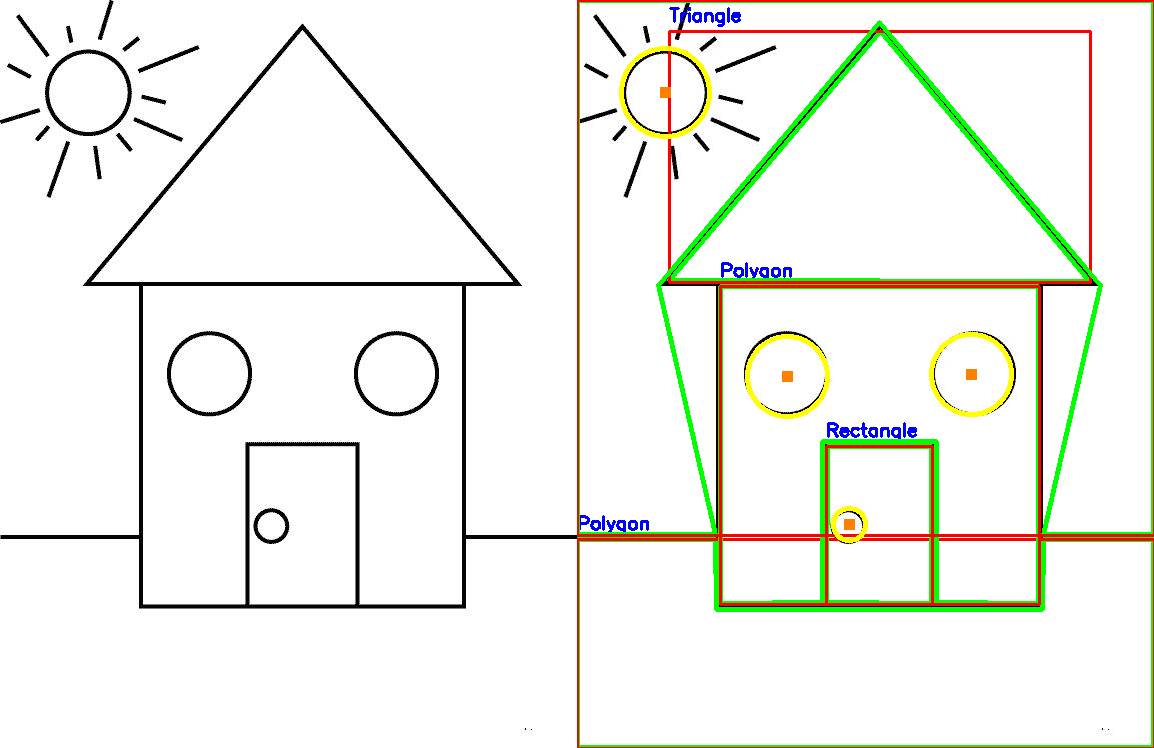

In [ ]:
# Load the image
image = cv2.imread("Pictures/drawing.jpg")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise before edge detection
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Use adaptive thresholding for better edge detection on varying lighting conditions
adaptive_thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# Find contours in the edge-detected image using adaptive thresholding
contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours based on area
contours = [c for c in contours if cv2.contourArea(c) > 100]  # Adjust based on the size of objects

# Create a copy of the original image to draw contours
contoured_image = image.copy()

# Iterate over each contour
for contour in contours:
    # Approximate the contour to a polygon with more precision
    epsilon = 0.02 * cv2.arcLength(contour, True)  # Lower epsilon for better precision
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Get the bounding box for the contour
    x, y, w, h = cv2.boundingRect(approx)

    # Draw the contour and bounding box
    cv2.drawContours(contoured_image, [approx], -1, (0, 255, 0), 3)  # Green contours
    cv2.rectangle(contoured_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red bounding boxes

    # Classify the shape based on the number of corners
    num_sides = len(approx)

    # Check if the shape is circular or polygonal using ellipse fitting for better detection
    if num_sides > 5:
        shape = "Polygon"
    elif num_sides == 4:
        aspect_ratio = float(w) / h
        shape = "Square" if 0.95 <= aspect_ratio <= 1.05 else "Rectangle"
    elif num_sides == 3:
        shape = "Triangle"
    else:
        # Using ellipse fitting for circles and ellipses
        (x_center, y_center), (major_axis, minor_axis), angle = cv2.fitEllipse(contour)
        if abs(major_axis - minor_axis) < 0.1 * major_axis:  # If the axes are nearly equal, it's a circle
            shape = "Circle"
        else:
            shape = "Ellipse"

    # Annotate the shape
    cv2.putText(contoured_image, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Hough Circle Transform to detect circles
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=50, param1=50, param2=30, minRadius=10, maxRadius=100)

if circles is not None:
    # Convert the circle coordinates to integers
    circles = np.round(circles[0, :]).astype("int")

    # Draw the circles
    for (x, y, r) in circles:
        cv2.circle(contoured_image, (x, y), r, (0, 255, 255), 4)  # Draw the circle
        cv2.rectangle(contoured_image, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)  # Draw center point

# Stack the original image and the processed one for comparison
display = np.hstack((image, contoured_image))

# Show the result
cv2_imshow(display)

## **14. Applying Image Blurring Techniques**

*   Demonstrate various image blurring methods (Gaussian blur, median blur) to soften details in an image.



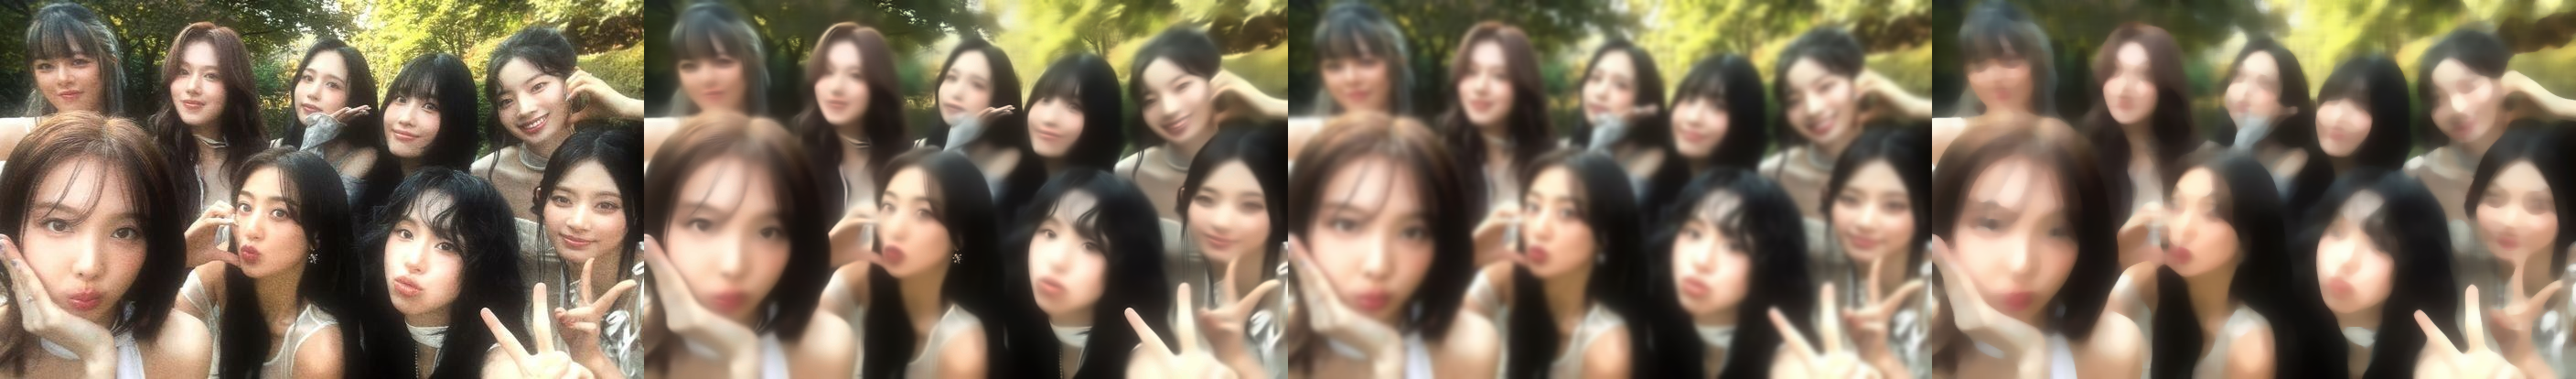

In [ ]:
# Load the image
image = cv2.imread("Pictures/twice.jpg")

# Denoise the image using fastNlMeansDenoisingColored
denoised = cv2.fastNlMeansDenoisingColored(image, None, 15, 15, 10, 15)

# Apply Gaussian blur
gaussian_blur = cv2.GaussianBlur(image, (15, 15), 0)  # Kernel size (15, 15)

# Apply Median blur
median_blur = cv2.medianBlur(image, 15)  # Kernel size must be odd

# Stack the images horizontally for comparison
display = np.hstack((image, denoised, gaussian_blur, median_blur))

# Display the result
cv2_imshow(display)

## **15. Segmenting Images Based on Contours**

*   Use contour detection to separate different sections of an image, like dividing a painting into its distinct elements.



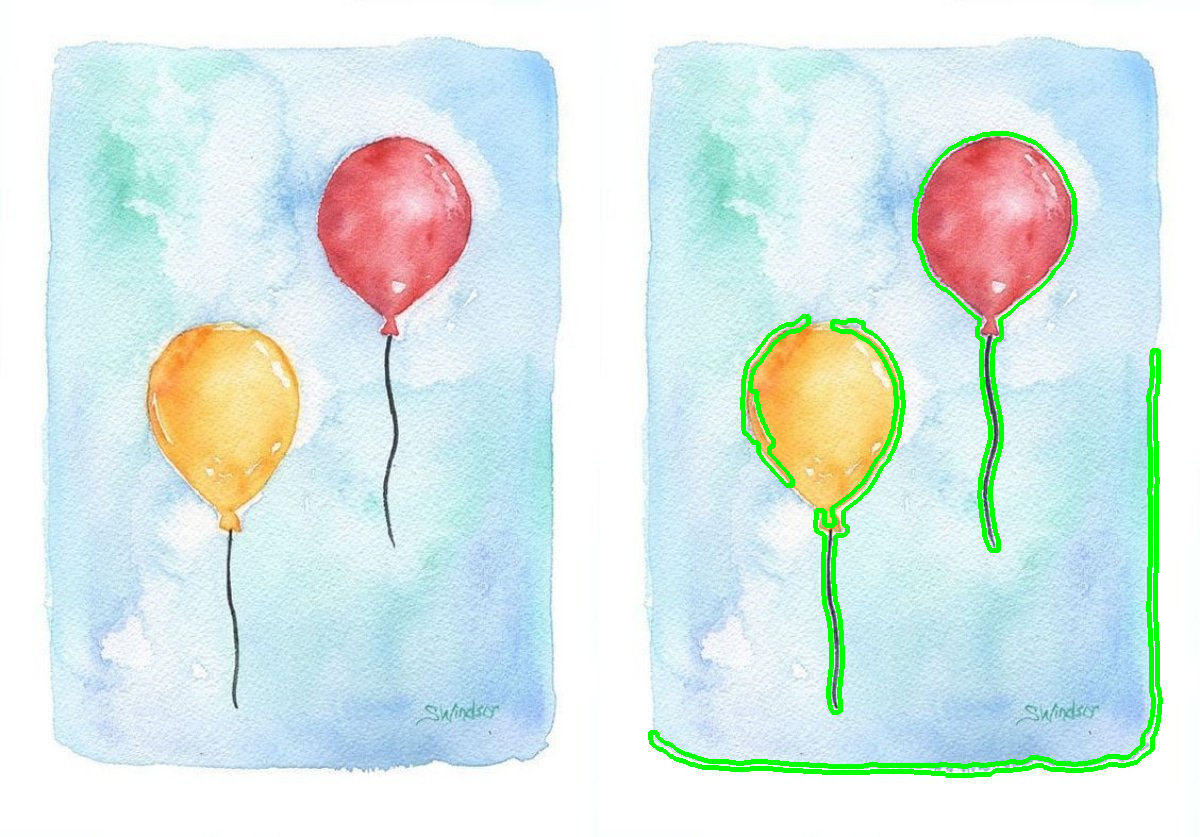

In [ ]:
# Load the image
image = cv2.imread("Pictures/paint.jpg")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to the grayscale image (helps in edge detection)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)  # Adjust kernel size if needed

# Use Canny edge detection to detect edges in the image
edges = cv2.Canny(blurred, 50, 150)  # Experiment with threshold values

# Apply morphological operations to improve the edges
kernel = np.ones((7, 7), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=2)  # Increase iterations for better results
edges = cv2.erode(edges, kernel, iterations=1)

# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter small contours by area (optional)
contours = [c for c in contours if cv2.contourArea(c) > 500]

# Create a copy of the original image to draw the contours on
contoured_image = image.copy()

# Draw contours on the original image
cv2.drawContours(contoured_image, contours, -1, (0, 255, 0), 3)  # Green contours

# Optional: Apply a color segmentation (if needed for better separation based on color)
# Convert the image to HSV for color segmentation
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the color range for segmentation (you may adjust these values)
lower_color = np.array([40, 50, 50])  # Example for greenish hues, adjust for the image's dominant color
upper_color = np.array([85, 255, 255])

# Create a mask for the selected color
mask = cv2.inRange(hsv, lower_color, upper_color)

# Stack the images for side-by-side comparison
display = np.hstack((image, contoured_image))

# Display the result
cv2_imshow(display)

## **16. Combining Erosion and Dilation for Feature Refinement**

*   Apply erosion followed by dilation on an image to refine and smooth out small features.



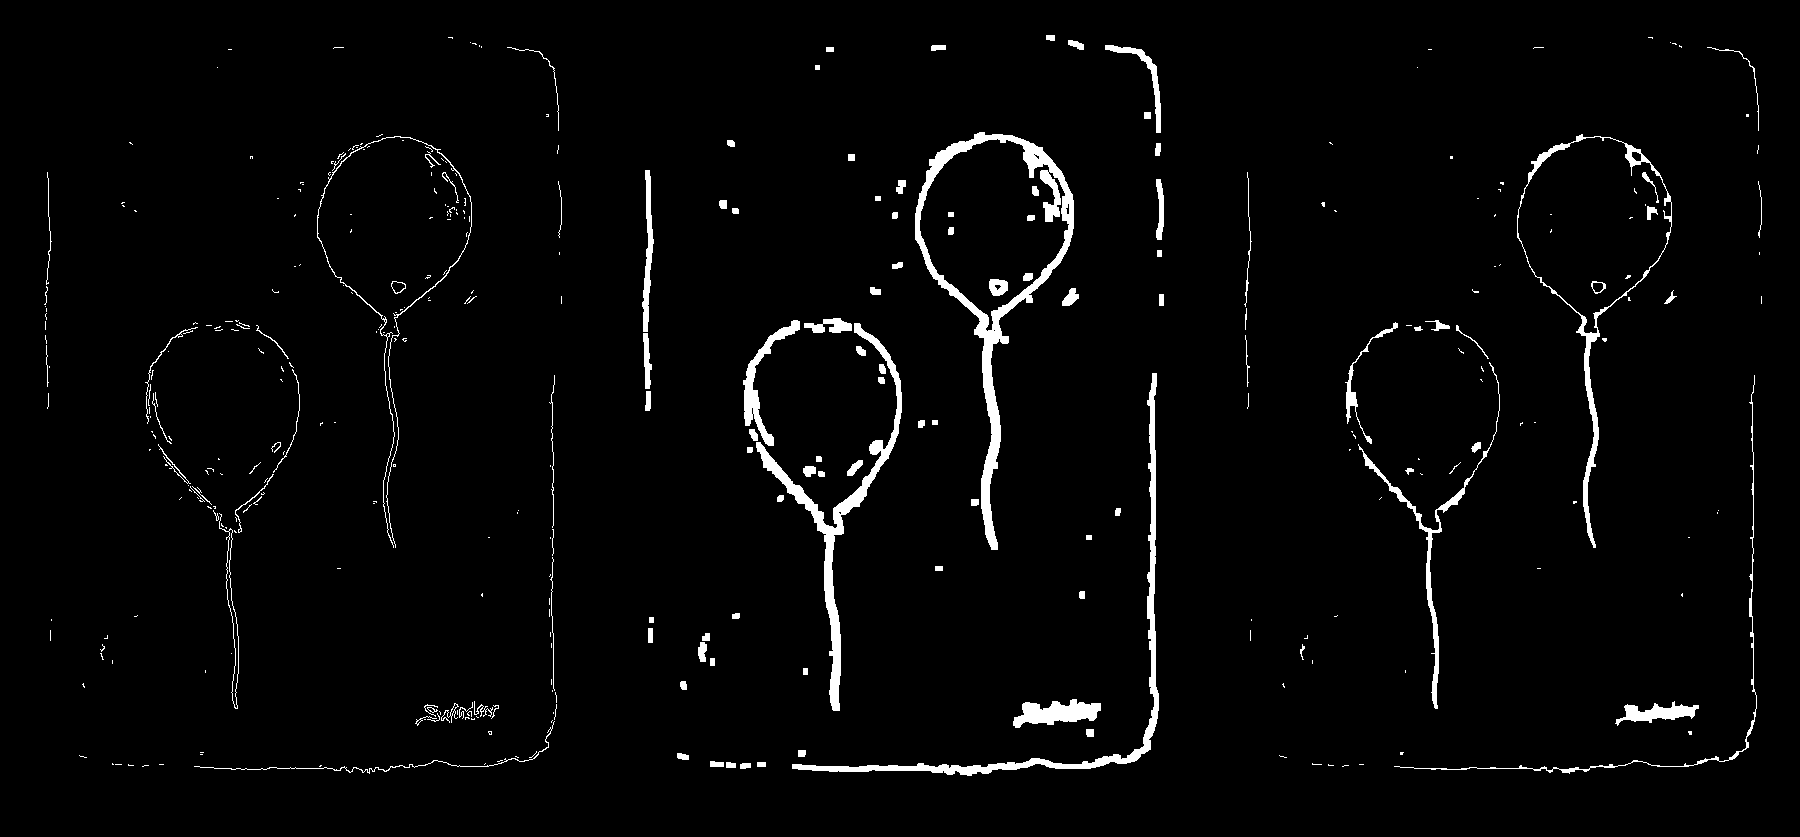

In [ ]:
# Load the image
image = cv2.imread("Pictures/paint.jpg")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection to the grayscale image
canny_image = cv2.Canny(gray, 150, 200)

# Create a kernel for morphological operations
kernel = np.ones((5, 5), np.uint8)  # 5x5 kernel for larger operation size

# Apply Dilation (expand the white regions)
dilated_image = cv2.dilate(canny_image, kernel, iterations=1)

# Apply Erosion (shrink the white regions)
eroded_image = cv2.erode(dilated_image, kernel, iterations=1)

# Stack the images for side-by-side comparison
display = np.hstack((canny_image, dilated_image, eroded_image))

# Display the result
cv2_imshow(display)